<center Plant Disease Detection Using CNN</center>



In [1]:
! git clone https://github.com/spMohanty/PlantVillage-Dataset

Cloning into 'PlantVillage-Dataset'...
remote: Enumerating objects: 163235, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 163235 (delta 2), reused 1 (delta 0), pack-reused 163229 (from 1)
Receiving objects: 100% (163235/163235), 2.00 GiB | 38.04 MiB/s, done.
Resolving deltas: 100% (101/101), done.
Updating files: 100% (182401/182401), done.


The **PlantVillage-Dataset** from GitHub, This dataset contains images of various plant diseases. **54K+ images**

Set the path to the root directory where the raw color images are stored.

In [2]:
DATASET_ROOT = "/content/PlantVillage-Dataset/raw/color"

List the contents of the dataset directory to verify the download.

`head` shows only the first few folders (the classes)

In [3]:
!ls $DATASET_ROOT | head

Apple___Apple_scab
Apple___Black_rot
Apple___Cedar_apple_rust
Apple___healthy
Blueberry___healthy
Cherry_(including_sour)___healthy
Cherry_(including_sour)___Powdery_mildew
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
Corn_(maize)___Common_rust_
Corn_(maize)___healthy


Install the necessary Python libraries for deep learning and data handling.

This ensures all dependencies are met for the rest of the code

In [4]:
# !pip install tensorflow tensorflow-datasets matplotlib seaborn scikit-learn

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
# Import specific modules from Keras for building the neural network.
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
img_size = (224, 224)
batch_size = 16

datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

In [7]:
train_gen = datagen.flow_from_directory(
    DATASET_ROOT,
    target_size=img_size,
    batch_size=batch_size,
    subset="training",
    class_mode="categorical"
)

Found 43456 images belonging to 38 classes.


In [8]:
val_gen = datagen.flow_from_directory(
    DATASET_ROOT,
    target_size=img_size,
    batch_size=batch_size,
    subset="validation",
    class_mode="categorical"
)

Found 10849 images belonging to 38 classes.


In [9]:
num_classes = len(train_gen.class_indices)
print("Classes:", train_gen.class_indices)

Classes: {'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___Late_blight': 30

Build Model (Transfer Learning)

Load a pre-trained EfficientNetB0 model.

`include_top=False` means we are only using the feature-extracting base,not the final classification layers.

Freeze the base model's layers so their weights are not updated during training.

In [10]:
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # Freeze base initially


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Add a GlobalAveragePooling2D layer on top of the base model's output.

This averages the feature maps, preparing the data for the final classification layers.

In [ ]:
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

Add a BatchNormalization layer to stabilize and speed up training.

In [ ]:
# Batch Normalisation
x = tf.keras.layers.BatchNormalization()(x)

Add a Dropout layer to randomly ignore some neurons, which helps prevent overfitting.

In [12]:
# Dropout for regularization
x = tf.keras.layers.Dropout(0.4)(x)

Add a fully connected (Dense) layer with 256 neurons and ReLU activation.

In [ ]:
x = tf.keras.layers.Dense(256, activation="relu")(x)

In [ ]:
# Batch Normalisation after dense layer
x = tf.keras.layers.BatchNormalization()(x)

In [14]:
x = tf.keras.layers.Dropout(0.4)(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

In [15]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Compile Model

In [16]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [18]:
import os
import shutil
import random

# Create train/val directories
train_dir = "/content/PlantVillage-Dataset/train"
val_dir = "/content/PlantVillage-Dataset/val"

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

In [19]:
# Loop over each class folder
dataset_dir = "/content/PlantVillage-Dataset/raw/color"
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        random.shuffle(images)
        split = int(len(images) * 0.8)  # 80% train, 20% val

        train_class_dir = os.path.join(train_dir, class_name)
        val_class_dir = os.path.join(val_dir, class_name)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(val_class_dir, exist_ok=True)

        # Move images
        for img in images[:split]:
            shutil.copy(os.path.join(class_path, img), train_class_dir)
        for img in images[split:]:
            shutil.copy(os.path.join(class_path, img), val_class_dir)

In [20]:
train_generator = train_datagen.flow_from_directory(
    '/content/PlantVillage-Dataset/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 43429 images belonging to 38 classes.


In [21]:
test_datagen = ImageDataGenerator(rescale=1./255)
val_generator = test_datagen.flow_from_directory(
    '/content/PlantVillage-Dataset/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 10876 images belonging to 38 classes.


In [22]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=25
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 545s 395ms/step - accuracy: 0.1940 - loss: 3.2355
Epoch 2/25
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 0s 13us/step - accuracy: 0.2500 - loss: 2.6803   
Epoch 3/25


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1357/1357 ━━━━━━━━━━━━━━━━━━━━ 535s 381ms/step - accuracy: 0.3431 - loss: 2.3061
Epoch 4/25
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 0s 12us/step - accuracy: 0.5000 - loss: 1.7751   
Epoch 5/25
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 519s 383ms/step - accuracy: 0.3922 - loss: 2.0788
Epoch 6/25
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 0s 10us/step - accuracy: 0.4688 - loss: 1.7474   
Epoch 7/25
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 519s 382ms/step - accuracy: 0.4318 - loss: 1.9409
Epoch 8/25
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 1s 9us/step - accuracy: 0.2500 - loss: 2.2436     
Epoch 9/25
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 510s 376ms/step - accuracy: 0.4575 - loss: 1.8308
Epoch 10/25
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 0s 11us/step - accuracy: 0.3438 - loss: 2.1974   
Epoch 11/25
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 513s 378ms/step - accuracy: 0.4745 - loss: 1.7693
Epoch 12/25
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 0s 10us/step - accuracy: 0.4375 - loss: 1.8669   
Epoch 13/25
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 510s 376ms/step - accuracy: 0.4946 - loss: 1

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,736,884 (273.65 MB)

 Trainable params: 23,912,294 (91.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 47,824,590 (182.44 MB)

KeyError: 'val_accuracy'

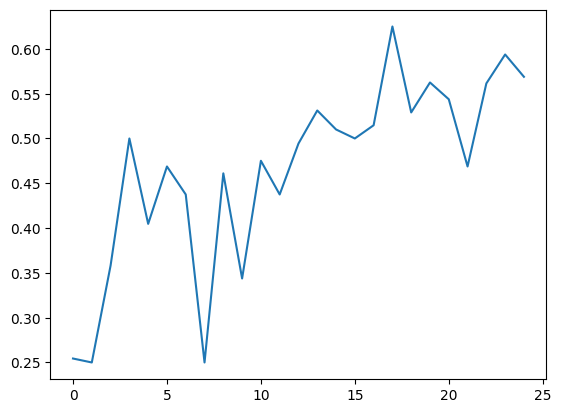

In [24]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

KeyError: 'val_loss'

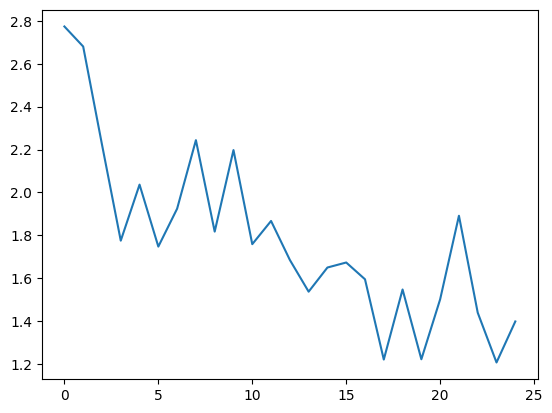

In [25]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()